**Link:** https://github.com/PetePriority/picoctf-2024/tree/main/cryptography/flag_printer

#### **1. Phân tích chương trình**

##### ***1.1. Quy trình của chương trình***
- 1. Đầu tiên, chương trình cho một số nguyên $q = MOD = 7514777789$

- 2. Tiếp theo, thực hiện lấy các giá trị $x_i$, $y_i$ từ file `encrypt.txt`. Sau đó, lưu vào một biến `point`

- 3. Tạo một trường $GF = GF(q)$

- 4. Tạo một ma trận $A$, sao cho mỗi hàng là các giá trị của $[1, x_i^2, \dots, x_i^{q-1}]$.Một vector $Y$ bao gồm tất cả các giá trị $y_i$.

- 5. Sử dụng tuyến tính để tính toán giá trị $X$: $$Y=AX+B \pmod{q}$$

##### ***1.2. Định hướng***

Có thể thấy, ma trận $A$ sẽ biểu diễn như sau, với $n=p-1$
$$ \begin{pmatrix}
1 & x_0 & x_0^2 & \cdots & x_0^n \\
1 & x_1 & x_1^2 & \cdots & x_1^n \\
1 & x_2 & x_2^2 & \cdots & x_2^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \cdots & x_n^n \\
\end{pmatrix} $$

- 1. Vấn đề đặt ra là số lượng phần tử trong $A$ là $(n - 1)^2 \approx 3 \times 10^{12}$ phần tử. Do đó, thời gian tính toán rất lớn: $O(n^s)$

- 2. Nhìn vào ma trận có thể thấy, bản chất của phép tính tuyến tính này là tìm các hệ số cho đa thức $P(x) = a_0 + a_1x + \dots + a_nx^n$ với tập hợp các bộ số $(x_i,y_i)$ thỏa mãn hệ thức. Các thuật toán (xem `Đa thức Lagrange`, `Đa thức Newton` ) được sử dụng để tính toán đa thức này. Tuy nhiên, thời gian vẫn rất lớn $O(n^2)$

- 3. Tuy nhiên, chúng ta có thể sử dụng [ansatz](https://mathoverflow.net/a/458091) sau đây và áp dụng phương pháp chia để trị của thuật toán FFT để giảm độ phức tạp tính toán đa thức. Độ phức tạp $O(n\text{log}_2^2n)$


##### ***1.3. Đa thức nội suy Largrange***

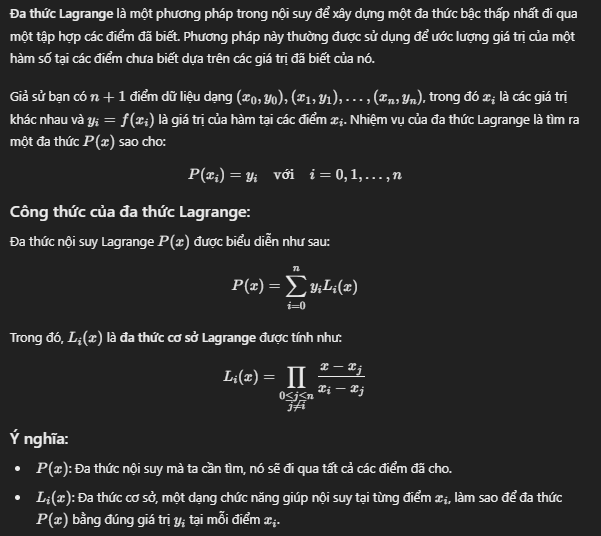

##### ***1.4. Thuật toán FFT***

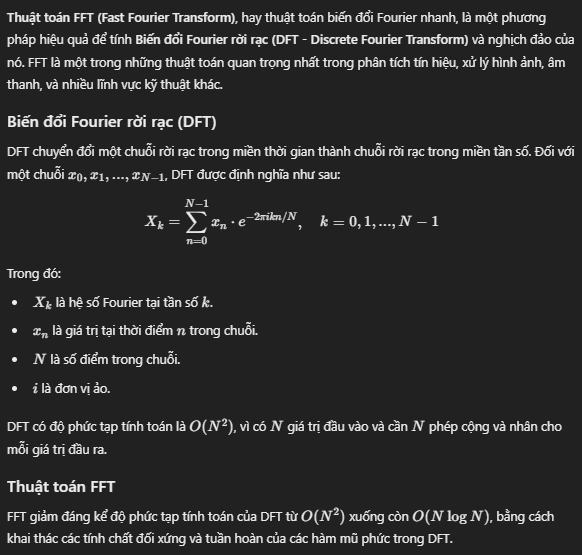
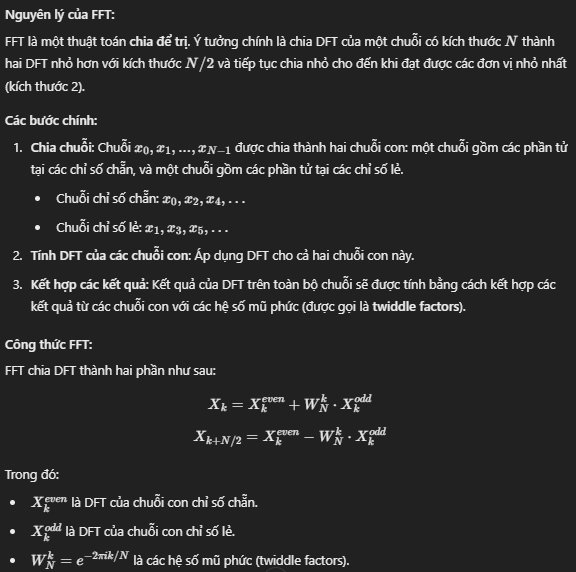


##### ***1.5. Kỹ thuật sử dụng***
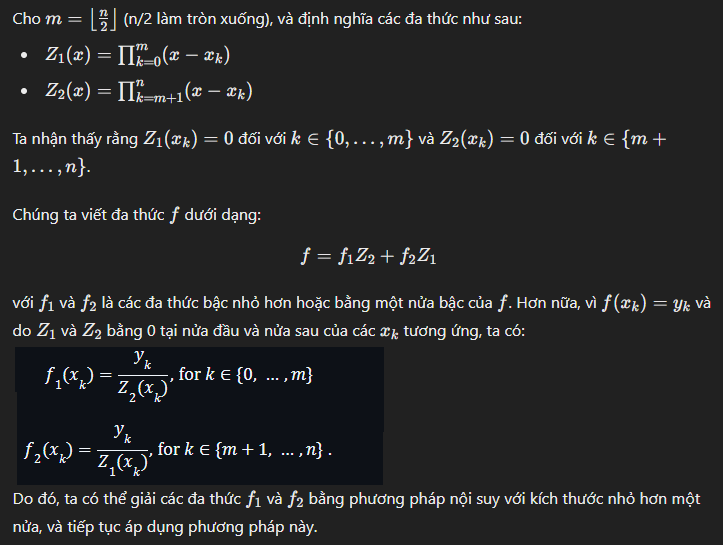

#### **2. Thực hiện viết mã**

[Tham khảo](https://github.com/PetePriority/picoctf-2024/blob/main/cryptography/flag_printer/solve_fast.ipynb)

In [ ]:
import multiprocessing as mp

p = 7514777789

X = []
Y = []
for line in open('encoded.txt', 'r').read().strip().split('\n'):
    x, y = line.split(' ')
    X.append(int(x))
    Y.append(int(y))

K = GF(p)
R = PolynomialRing(K, 'x')

def compZ(X):
    x = R.gen()
    Z = K(1)
    for xk in X:
        Z *= (x-xk)
    return Z

def comp(X, Y, Xother):
    Z = compZ(Xother)
    Y = [y/Z(x) for x, y in zip(X, Y)]
    return Y, Z

def solve(X, Y):
    n = len(Y)
    print("Solving for", n, "points...")

    # just use lagrange interpolation if the degree is small enough
    if n <= 10:
        return R.lagrange_polynomial(list(zip(X, Y)))

    nhalf = n // 2

    X1 = X[:nhalf]
    Y1 = Y[:nhalf]
    X2 = X[nhalf:]
    Y2 = Y[nhalf:]

    # parallelize the computation of the two halves
    if nhalf > 10000:
        with mp.Pool(2) as pool:
            result1 = pool.apply_async(comp, (X1, Y1, X2))
            result2 = pool.apply_async(comp, (X2, Y2, X1))

            Y1, Z2 = result1.get()
            Y2, Z1 = result2.get()
    else:
        Y1, Z2 = comp(X1, Y1, X2)
        Y2, Z1 = comp(X2, Y2, X1)

    # solve recursively
    f1 = solve(X1, Y1)
    f2 = solve(X2, Y2)

    # put it back together
    return f1*Z2 + f2*Z1

def test():
    Xt = X[:1000]
    Yt = Y[:1000]
    f = solve(Xt, Yt)
    for x, y in zip(Xt, Yt):
        assert f(x) == y

test()

f = solve(X, Y)

open("output.bmp", "wb").write(bytearray(f.coefficients(sparse=False)[:-1]))

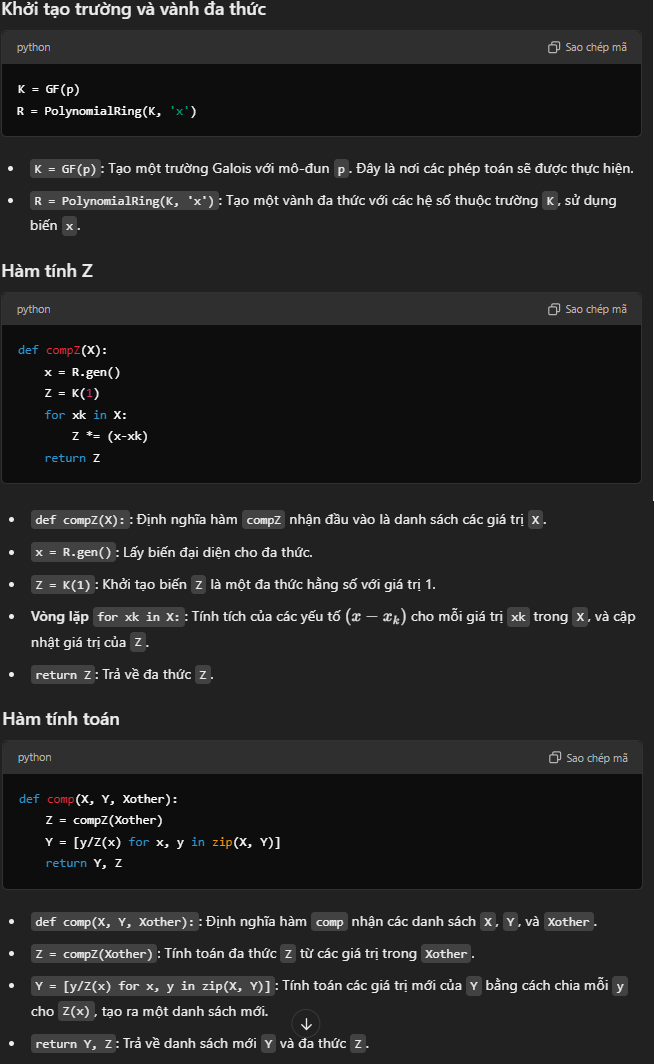

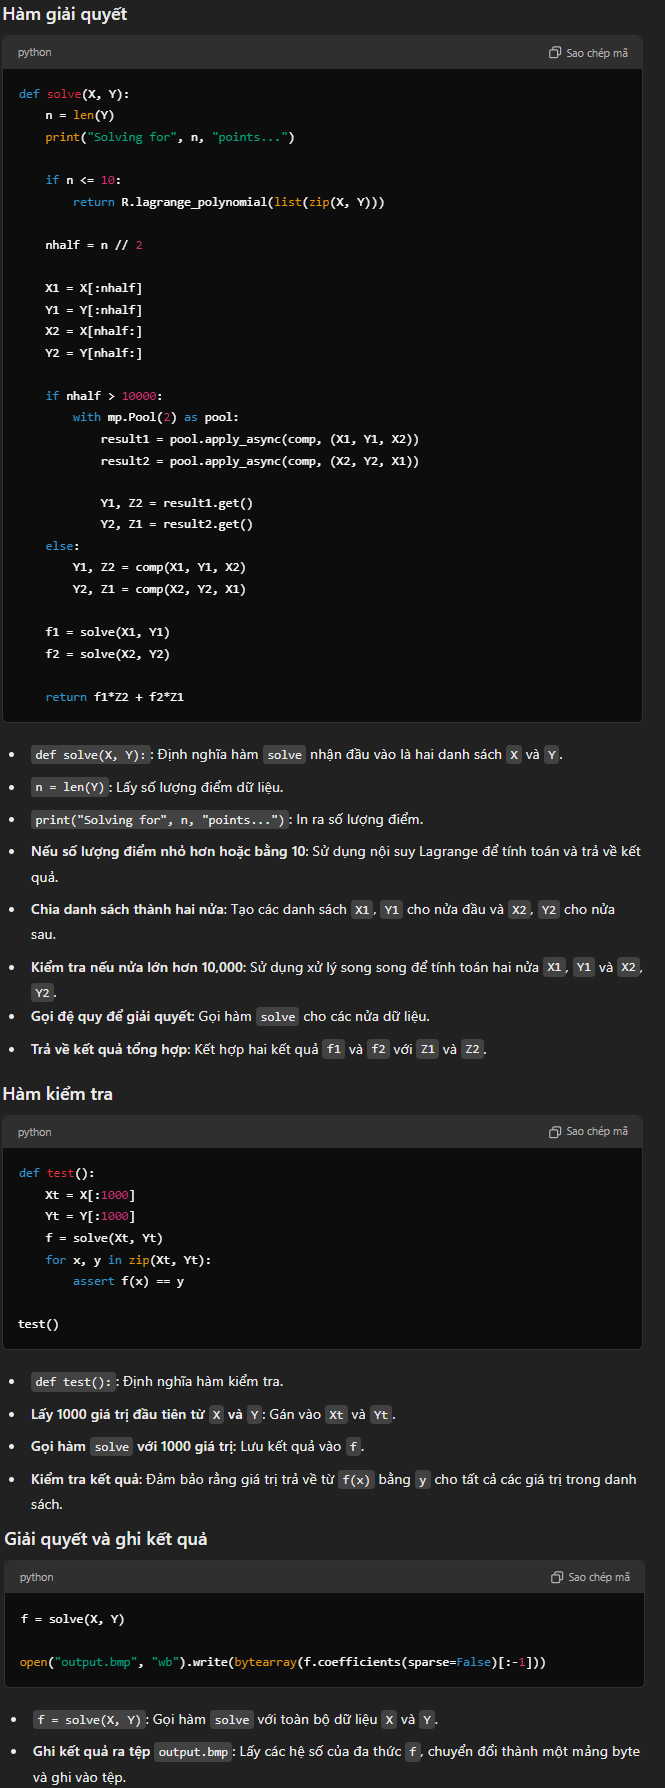